In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout

In [2]:
np.random.seed(42)
data_length = 2000
trend = np.linspace(100, 200, data_length)
noise = np.random.normal(0, 2, data_length)
synthetic_data = trend + noise

data = pd.DataFrame(synthetic_data, columns=['Close'])
data.to_csv("dataset/stock_prices.csv", index=False)

In [3]:
df = pd.read_csv("dataset/stock_prices.csv")
data = df[['Close']].values

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

In [7]:
def create_dataset(data_, time_step_=1):
    X_, y_ = [], []

    for i in range(len(data_)-time_step_-1):
        X_.append(data_[i:i+time_step_])
        y_.append(data_[i+time_step_])
    return np.array(X_), np.array(y_)

time_step = 100
X, y = create_dataset(data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

print("Shape of X: ", X.shape)
print("Shape of y: ", y.shape)

Shape of X:  (1899, 100, 1)
Shape of y:  (1899, 1)


### Implement Multi-Head Self-Attention

In [20]:
class MultiHeadAttention(Layer):
    def __init__(self, embed_dim, num_heads = 8):
        super(MultiHeadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.projection_dim = embed_dim // num_heads
        self.query_dense = Dense(embed_dim)
        self.key_dense = Dense(embed_dim)
        self.value_dense = Dense(embed_dim)
        self.combine_heads = Dense(embed_dim)

    @staticmethod
    def attention(query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        # Split
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        #
        attention, _ = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        return output

### Implement Transformer block

In [21]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=.1):
        super(TransformerBlock, self).__init__()
        self.attn = MultiHeadAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.attn(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

### Implement Encoder Layer

In [22]:
class EncoderLayer(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=.1):
        super(EncoderLayer, self).__init__()
        self.attn = MultiHeadAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.attn(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

### Implement Transformer Encoder

In [15]:
class TransformerEncoder(Layer):
    def __init__(self, num_layers, embed_dim, num_heads, ff_dim, rate=.1):
        super(TransformerEncoder, self).__init__()
        self.num_layers = num_layers
        self.embed_dim = embed_dim
        self.enc_layers = [TransformerBlock(embed_dim, num_heads, ff_dim, rate=rate) for _ in range(num_layers)]
        self.dropout = Dropout(rate)

    def call(self, inputs, training=False):
        X_ = inputs
        for i in range(self.num_layers):
            X_ = self.enc_layers[i](X_, training=training)
        return X_

### Build and Compile the Transformer model

In [33]:
# Define parameters
embed_dim_ = 128
num_heads_ = 8
ff_dim_ = 512
num_layers_ = 4

# Define Transformer Encoder
transformer_encoder = TransformerEncoder(num_layers_, embed_dim_, num_heads_, ff_dim_)

# Build the model
input_shape = (X.shape[1], X.shape[2])
inputs_ = tf.keras.Input(shape=input_shape)

# Project the inputs the embed_dim
x_ = tf.keras.layers.Dense(embed_dim_)(inputs_)
encoder_outputs = transformer_encoder(x_)
flatten = tf.keras.layers.Flatten()(encoder_outputs)
outputs = tf.keras.layers.Dense(1)(flatten)
model = tf.keras.Model(inputs=inputs_, outputs=outputs)

In [34]:
# compile the model
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_154 (Dense)               │ (None, 100, 128)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_5           │ (None, 100, 128)       │       793,088 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_155 (Dense)               │ (None, 1)              │        12,801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 806,145 (3.08 MB)

 Trainable params: 806,145 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
model.fit(X, y, epochs=20, batch_size=32)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 28s 312ms/step - loss: 13.1287
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 293ms/step - loss: 0.2321
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 283ms/step - loss: 0.1756
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 281ms/step - loss: 0.2397
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 278ms/step - loss: 0.1550
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 287ms/step - loss: 0.1437
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 308ms/step - loss: 0.1325
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 284ms/step - loss: 0.1149
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 284ms/step - loss: 0.1744
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 291ms/step - loss: 0.1145
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 307ms/step - loss: 0.1032
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 290ms/step - loss: 0.0827
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 283ms/step - loss: 0.0786
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 278ms/step - loss: 0.1334
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s

60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step


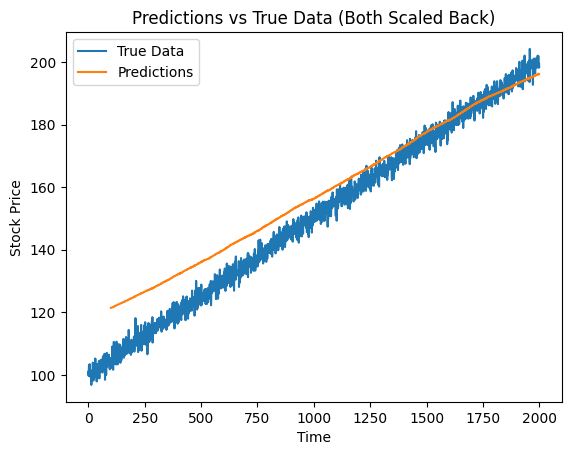

In [41]:
import matplotlib.pyplot as plt

predictions = model.predict(X)
predictions = scaler.inverse_transform(predictions)

true_values = scaler.inverse_transform(data.reshape(-1, 1))

plt.plot(true_values, label='True Data')
plt.plot(np.arange(time_step, time_step + len(predictions)), predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.title('Predictions vs True Data (Both Scaled Back)')
plt.show()